Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts.clean import clean_dataset
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X)


num_features = df._get_numeric_data().columns.to_list()
cate_features = df.select_dtypes(include=['object','category']).columns.to_list()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [3]:
y = df['income']
X = df.drop('income', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 9.37 s


array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.73      0.62      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



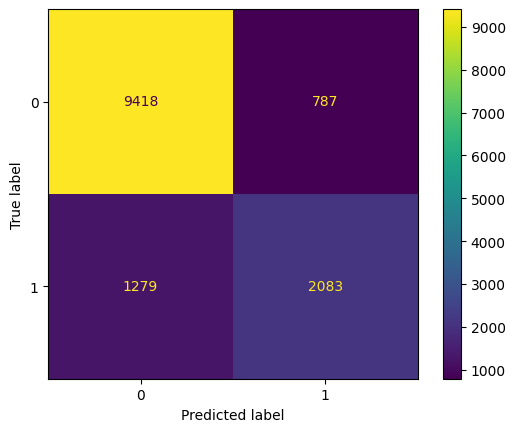

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    missing_subgroup_val="Unknown",
    drop_infeasible = True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 1728/1728 [00:09<00:00, 191.15it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 4886/4886 [03:48<00:00, 21.43it/s]

Number of if-thens: 4886


In [7]:
### Uncomment if you wish to load rules object from disk

import dill

with open("rulesAdultFairTest_preproc.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [ ]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest_preproc.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [8]:
ifthens = gfacts.rulesbyif2rules(rules_by_if)

In [10]:
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if gfacts.recIsValid(ifs,then,True)]

In [12]:
rules_by_if = gfacts.rules2rulesbyif(ifthens)

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 1.89% covered
		Make education-num = 13, hours-per-week = OverTime with correctness 12.82%.
		Make education-num = 13, hours-per-week = OverTime with correctness 12.82%.
	Protected Subgroup ' Male', 2.15% covered
		Make education-num = 13, hours-per-week = OverTime with correctness 69.23%.
		Make education-num = 13, hours-per-week = OverTime with correctness 69.23%.
If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Female', 2.18% covered
		Make education-num = 13, hours-per-week = OverTime with correctness 11.11%.
		Make education-num = 13, hours-per-week = OverTime with correctness 11.11%.
	Protected Subgroup ' Male', 2.42% covered
		Make education-num 

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [14]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20, "capital-gain": 0.001}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.naive_feature_change_builder(
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10,
    filter_sequence=["remove-contained"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.19% covered out of 14695
		Make occupation =  Exec-managerial with correctness 0.00%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Exec-managerial with correctness 0.00%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 1.17% covered out of 30527
		Make occupation =  Exec-managerial with correctness 39.74%.
		Make occupation =  Prof-specialty with correctness 15.38%.
		Make occupation =  Exec-managerial with correctness 39.74%.
		Make occupation =  Prof-specialty with correctness 15.38%.
		Aggregate cost of the above recourses = -0.28
	Bias against  Female. Unfairness measure = 0.28.
If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, occupation =  Machine-op-inspct:
	Protected Subgroup ' Fem

## Minimum cost above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-exists-subgroup-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr", "remove-fair-rules","keep-only-min-change"],
    secondary_sorting=True,
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age = (34.0, 41.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.60% covered out of 14695
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 56.07%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 56.07%.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' Male', 2.58% covered out of 30527
		Make age = (41.0, 50.0], capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with correctness 81.98%.
		Make age = (41.0, 50.0], capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with correctness 81.98%.
		Aggregate cost of the above recourses = 1914.00
	Bias against  Male. Unfairness measure = 1903.
If age = (34.0, 41.0], capital-loss = 0, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.16% covered out of 14695

## Mean cost above threshold

In [18]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr", "remove-fair-rules"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-loss = 0, education-num = 9:
	Protected Subgroup ' Female', 31.06% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 39.64% covered out of 30527
		Make capital-loss = 1902, education-num = 13 with correctness 53.99%.
		Make capital-loss = 1902, education-num = 13 with correctness 53.99%.
		Aggregate cost of the above recourses = 1982.00
	Bias against  Female. Unfairness measure = inf.
If capital-loss = 0, education-num = 9, race =  White:
	Protected Subgroup ' Female', 24.53% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 34.50% covered out of 30527
		Make capital-loss = 1902, education-num = 13 with correctness 56.07%.
		Make capital-loss = 1902, education-num = 13 with correctness 56.07%.
		Aggregate cost of the above recourses = 1982.00
	Bias against  Female. Unfairness measure = inf.
If education-num = 9, hours

## Number above threshold

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If education-num = 9, hours-per-week = FullTime, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.92% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' Male', 3.44% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 53.28%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 52.84%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 51.97%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Sales with correctness 51.97%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 53.28%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 52.84%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 55.90%.
		Make education-num = 14, hours-per-week = OverTime, 

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [ ]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

FileNotFoundError: [Errno 2] No such file or directory: 'stateAdultFairTest.data'

If education-num = 9, hours-per-week = FullTime, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.92% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 3.44% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 53.28%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 52.84%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 51.97%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Sales with correctness 51.97%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 53.28%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 52.84%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 55.90%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 5

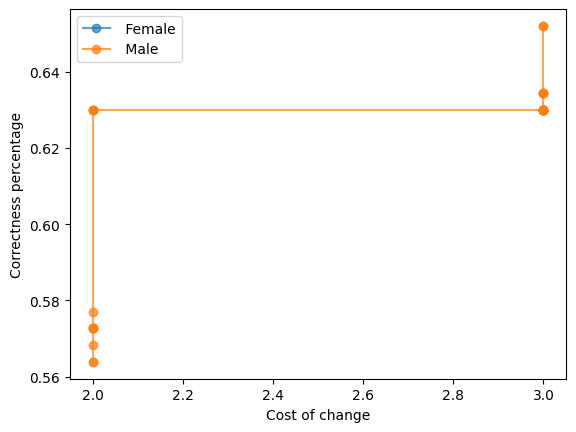

If education-num = 9, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Female', 1.55% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.13% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 57.33%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 56.00%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 56.00%.
		Make education-num = 13, hours-per-week = OverTime with correctness 56.00%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 57.33%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 56.00%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 60.00%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 57.33%.
		Make education-num = 10,

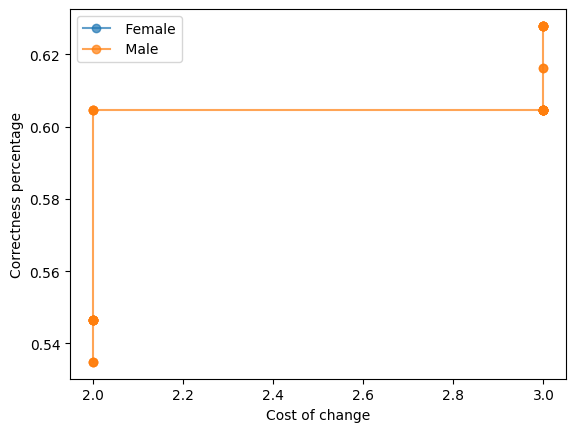

If Workclass =  Private, age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 1.19% covered out of 14695
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 73.47%.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 63.27%.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 67.35%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 61.22%.
		Make age = (50.0, 90.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 69.39%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 59.18%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain, marital-status =  Married

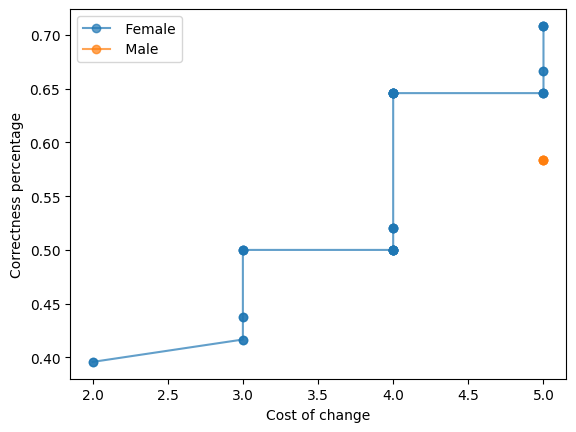

If capital-loss = 0, education-num = 9, hours-per-week = FullTime, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.92% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 3.36% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 53.57%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 53.12%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 52.23%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 53.57%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Sales with correctness 52.23%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 55.80%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 53.12%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial

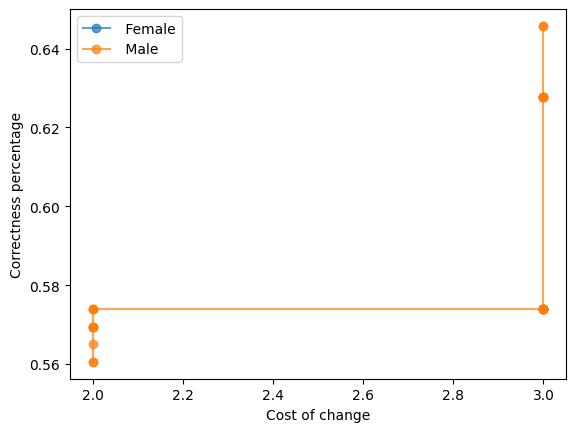

If capital-loss = 0, education-num = 9, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Female', 1.43% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.10% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 57.53%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 57.53%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 57.53%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 57.53%.
		Make education-num = 13, hours-per-week = OverTime with correctness 57.53%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 60.27%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 57.53%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 57.53%.
		Make 

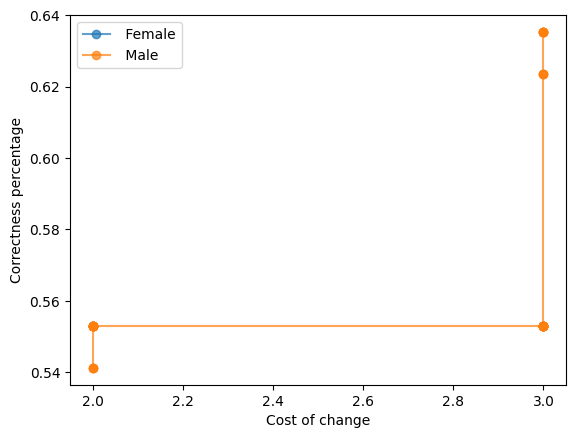

If education-num = 9, hours-per-week = FullTime, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Female', 1.33% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.85% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 55.79%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 55.26%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 54.74%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Sales with correctness 54.74%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 55.79%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 58.95%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 55.26%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial wi

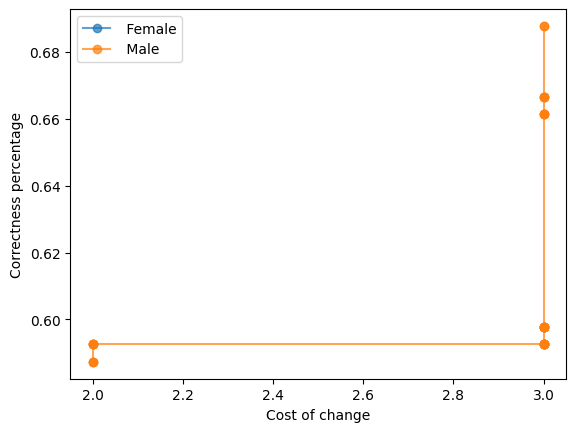

If education-num = 9, hours-per-week = FullTime, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 1.33% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.02% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 60.29%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 58.82%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 58.82%.
		Make education-num = 13, hours-per-week = OverTime with correctness 58.82%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 60.29%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 63.24%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 58.82%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 58.82%.
		Make edu

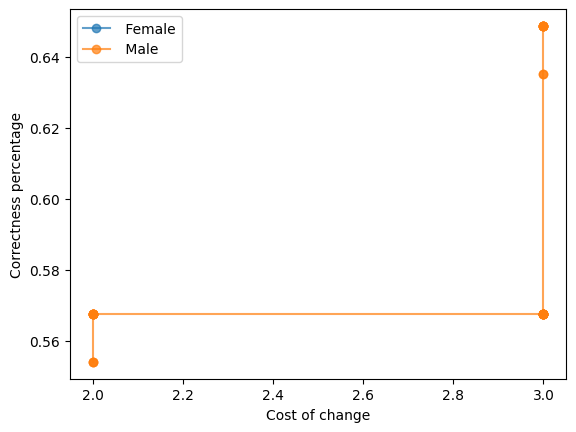

If Workclass =  Private, age = (26.0, 34.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.62% covered out of 14695
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 77.78%.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 57.41%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 62.96%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 51.85%.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.93%.
		Make age = (50.0, 90.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 63.89%.
		Make age = (34.0, 41.0], marital

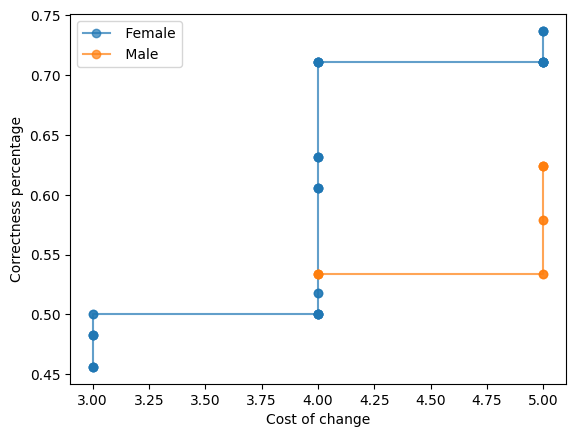

If education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Other-service, race =  White:
	Protected Subgroup ' Female', 1.77% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.22% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 53.09%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 53.09%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 53.09%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Sales with correctness 53.09%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 53.09%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 55.56%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 53.09%.
		Make education-num = 10, hours-per-week = OverTime, occ

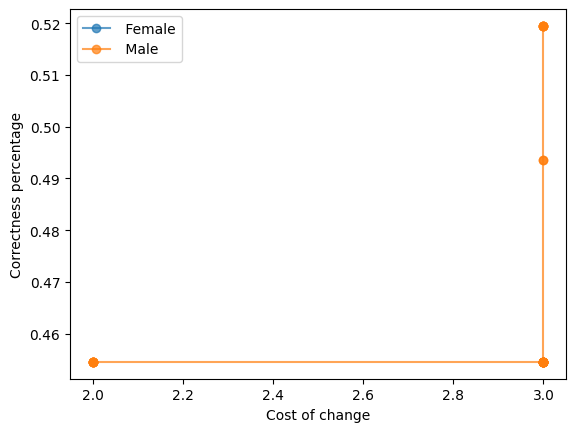

If education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.63% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 3.11% covered out of 30527
		Make education-num = 13, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 53.14%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 52.66%.
		Make education-num = 13, occupation =  Prof-specialty with correctness 51.69%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Sales with correctness 51.69%.
		Make education-num = 13, hours-per-week = OverTime, occupation =  Prof-specialty with correctness 53.14%.
		Make education-num = 14, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 56.04%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 52.66%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  

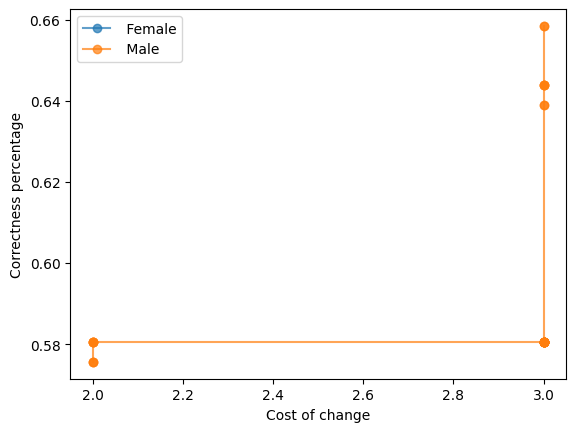

In [20]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex")

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [ ]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)